<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/jedi3/Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs & Data

In [53]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [54]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [55]:
from sklearn.pipeline import make_pipeline


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix, roc_auc_score, roc_curve

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [56]:
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [57]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Helper function

In [58]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

################################

def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(clean_text(text)), style='ent', jupyter=True)

################################

def corpus_func(series):
    '''create a text block (corpus) from a series'''
    return " #### ".join(text for text in series)

def corpus_list(corpus):
    '''create a list from text block (corpus)'''
    corpus_list = lambda x: x.split(' #### ')

In [59]:
#jedi's helpers
#
def my_fit_cm(df, pipe, feature_list, target):
  # includes train test split, model fit, and
  # plots confusion matrix
  #

  X_train, X_test,\
  y_train, y_test =\
  train_test_split(df[feature_list],
                    df[target],
                    test_size=0.2,
                    random_state=314159,
                    stratify=df[target])

  #display( cross_val_score(pipe, X_train, y_train).mean() )

  pipe.fit(X_train, y_train)
  plot_confusion_matrix(pipe, X_train, y_train, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_train, pipe.predict(X_train)):0.3f}")
  
  plot_confusion_matrix(pipe, X_test, y_test, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_test, pipe.predict(X_test)):0.3f}")
  plt.show()

# ROC curve ##
  plt.plot([0, 1], [0, 1], 'k--')
  fpr, tpr, thresholds = roc_curve(y_train, pipe.predict_proba(X_train)[:, 1] )
  plt.plot(fpr, tpr, label='train')

  fpr_, tpr_, thresholds_ = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1] )
  plt.plot(fpr_, tpr_, label='test')

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  return fpr_, tpr_ # for further plotting ...
  # end


In [60]:
#PW
# new helper of PW

In [61]:
#OCF


## Evaluate data

In [62]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [63]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [64]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [65]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [66]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [67]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

## Visualization of data (of)

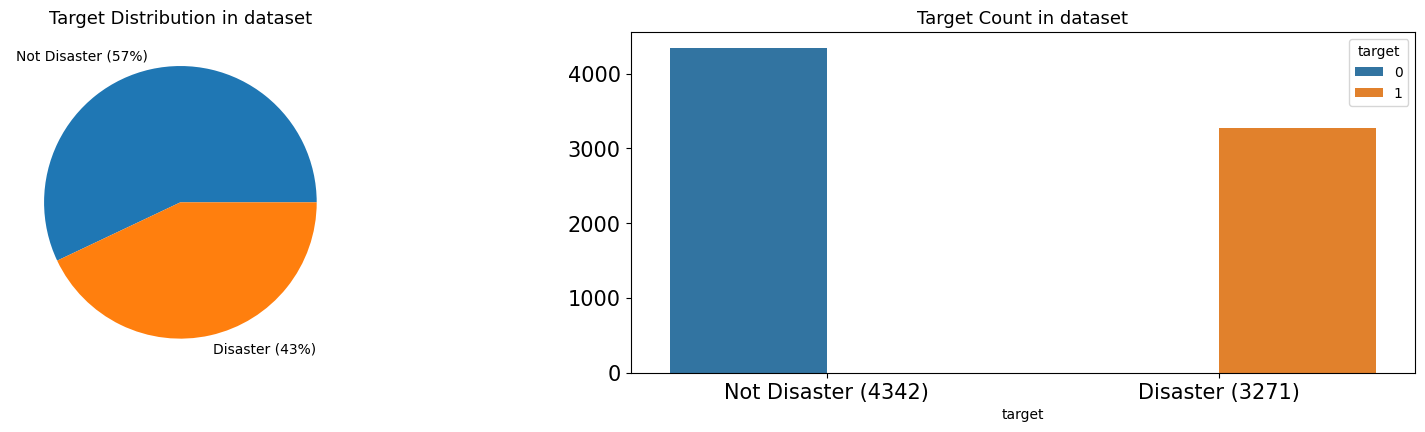

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

disaster_tweets.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=disaster_tweets['target'], hue=disaster_tweets['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

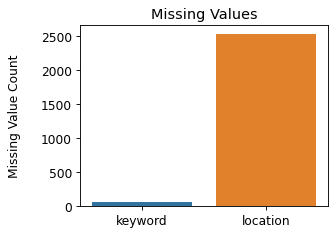

In [69]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

In [70]:
dtt_clean = disaster_tweets.copy()

### clean NaN

In [71]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [72]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1


# Analizing tweet < text >
- NLP text 
- NLP keyword, localization 

In [73]:
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [74]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1


In [75]:
#Regex:
dtt_clean['keyword_re'] = dtt_clean.keyword.apply(lambda text: re.sub("%20"," ", text))  # leerzeichen !!!

In [76]:
# analog to goupby in Evaluate data (but after clean keyword)
# make a count for the keyword list

key_count = sorted(Counter(list(dtt_clean['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_count[0:20])

[('no_keyword', 61), ('fatalities', 45), ('deluge', 42), ('armageddon', 42), ('sinking', 41), ('harm', 41), ('damage', 41), ('body bags', 41), ('windstorm', 40), ('twister', 40), ('siren', 40), ('outbreak', 40), ('fear', 40), ('evacuate', 40), ('collided', 40), ('wrecked', 39), ('wreckage', 39), ('whirlwind', 39), ('weapons', 39), ('weapon', 39)]


In [77]:
keyword_low=[x.lower() for x in dtt_clean['keyword_re']]

In [78]:
stemmer = PorterStemmer()

newColumn = []
for w in keyword_low: 
    newColumn.append(stemmer.stem(w))

dtt_clean['keyword_clean'] = newColumn

In [79]:
print(f"key_unique, org:     {len(keys)}\t locations: {len(locations)}")
print(f"key_unique, regex:   {len(dtt_clean['keyword_re'].unique())}")
print(f"key_unique, stemmed: {len(dtt_clean['keyword_clean'].unique())}")

key_unique, org:     222	 locations: 3342
key_unique, regex:   222
key_unique, stemmed: 167


In [80]:
dtt_clean

,id,keyword,location,text,target,keyword_re,keyword_clean
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1,no_keyword,no_keyword
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,no_keyword,no_keyword
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1,no_keyword,no_keyword
3,6,no_keyword,no_location,people receive wildfire evacuation order calif...,1,no_keyword,no_keyword
4,7,no_keyword,no_location,got sent photo ruby alaska smoke wildfire pour...,1,no_keyword,no_keyword
...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,two giant crane holding bridge collapse nearby...,1,no_keyword,no_keyword
7609,10870,no_keyword,no_location,aria ahrary thetawniest control wild fire cali...,1,no_keyword,no_keyword
7610,10871,no_keyword,no_location,utc km volcano hawaii http co zdtoyd ebj,1,no_keyword,no_keyword
7611,10872,no_keyword,no_location,police investigating e bike collided car littl...,1,no_keyword,no_keyword


In [81]:
no_target_ = dtt_clean[ dtt_clean.target == 0]
target_    = dtt_clean[ dtt_clean.target == 1]

##Distribution of the key words to disaster (= 1) and false message (= 0)

In [82]:
df = dtt_clean.copy()

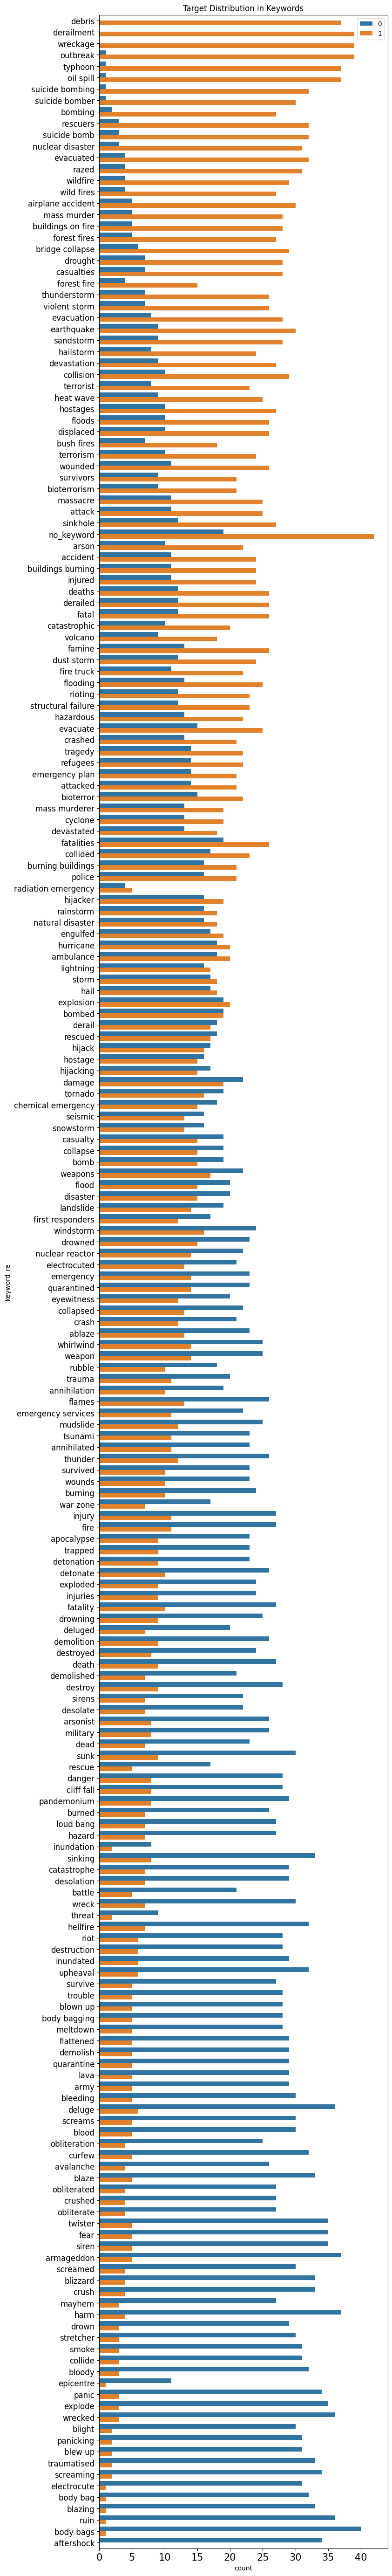

In [83]:
# with regex (ggf durch stemmed-version ersetzen)
df['target_mean'] = df.groupby('keyword_re')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['keyword_re'],
              hue=df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df.drop(columns=['target_mean'], inplace=True)

# new features

+ word_count number of words in text
+ unique_word_count number of unique words in text
+ stop_word_count number of stop words in text
+ url_count number of urls in text
+ mean_word_length average character count in words
+ char_count number of characters in text
+ punctuation_count number of punctuations in text
+ hashtag_count number of hashtags (#) in text
+ mention_count number of mentions (@) in text

In [84]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(len)

# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7613 non-null   int64  
 1   keyword            7613 non-null   object 
 2   location           7613 non-null   object 
 3   text               7613 non-null   object 
 4   target             7613 non-null   int64  
 5   keyword_re         7613 non-null   object 
 6   keyword_clean      7613 non-null   object 
 7   word_count         7613 non-null   int64  
 8   unique_word_count  7613 non-null   int64  
 9   stop_word_count    7613 non-null   int64  
 10  url_count          7613 non-null   int64  
 11  mean_word_length   7613 non-null   float64
 12  char_count         7613 non-null   int64  
 13  punctuation_count  7613 non-null   int64  
 14  hashtag_count      7613 non-null   int64  
 15  mention_count      7613 non-null   int64  
dtypes: float64(1), int64(10)

In [86]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'keyword_re',
       'keyword_clean', 'word_count', 'unique_word_count', 'stop_word_count',
       'url_count', 'mean_word_length', 'char_count', 'punctuation_count',
       'hashtag_count', 'mention_count'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


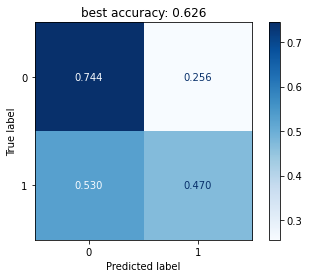

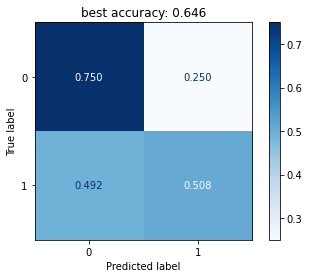

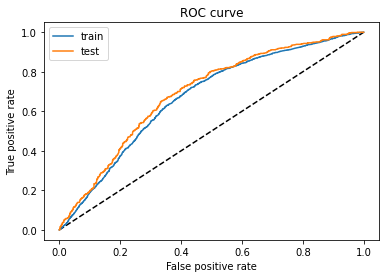

CPU times: user 823 ms, sys: 410 ms, total: 1.23 s
Wall time: 751 ms


(array([0.        , 0.00115075, 0.00115075, 0.0023015 , 0.0023015 ,
        0.00345224, 0.00345224, 0.00575374, 0.00575374, 0.00690449,
        0.00690449, 0.00920598, 0.00920598, 0.01035673, 0.01035673,
        0.01035673, 0.01150748, 0.01150748, 0.01495972, 0.01495972,
        0.01495972, 0.01495972, 0.01726122, 0.01726122, 0.02071346,
        0.02186421, 0.02186421, 0.02531646, 0.02761795, 0.02761795,
        0.0287687 , 0.0310702 , 0.0310702 , 0.03222094, 0.03222094,
        0.03337169, 0.03337169, 0.03337169, 0.03452244, 0.03452244,
        0.03452244, 0.03567319, 0.03567319, 0.03682394, 0.03682394,
        0.03682394, 0.03682394, 0.04027618, 0.04027618, 0.04257768,
        0.04257768, 0.04487917, 0.04487917, 0.04602992, 0.04602992,
        0.04602992, 0.04718067, 0.04718067, 0.04833142, 0.04833142,
        0.05063291, 0.05063291, 0.05293441, 0.05293441, 0.05408516,
        0.05408516, 0.0552359 , 0.0552359 , 0.05638665, 0.05638665,
        0.0575374 , 0.05868815, 0.05868815, 0.05

In [87]:
feature_list = ['word_count', 'unique_word_count', 'stop_word_count',
       'url_count', 'mean_word_length', 'char_count', 'punctuation_count',
       'hashtag_count', 'mention_count']
# next try
pipe = make_pipeline( LogisticRegression() ) 
%time my_fit_cm(df, pipe, feature_list, "target");

## jedi playground

In [88]:
test_text = "Barbados #Bridgetown JAMAICA Â\x89Ã\x9bÃ\x92 Two cars set ablaze: SANTA CRUZ Â\x89Ã\x9bÃ\x93 Head of the St Elizabeth Police Superintende"
#test_text = 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
#test_text = "#stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident teeÂ\x89Ã\x9b_"
spcy_test(test_text)


In [89]:
test_df = disaster_tweets[40:60]
#list(test_df.text)

In [90]:
%time df1 = my_df_spacy_locgpe(test_df.copy(), 'text')
#df1

CPU times: user 240 ms, sys: 981 µs, total: 241 ms
Wall time: 242 ms


In [91]:
#df2 = my_df_spacy_fac   (df1.copy(), 'text')
#df2

# Evaluationg Basic modeling

## Train-Test-Split

##pipline Tfidf, MultinomialNB

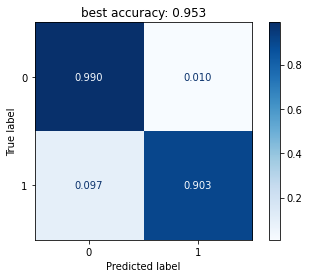

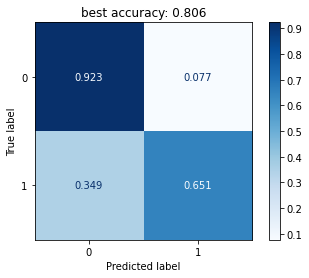

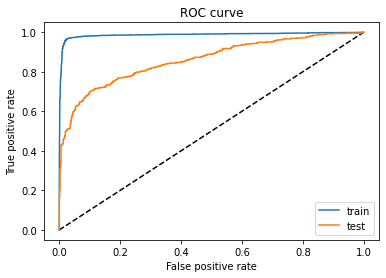

CPU times: user 1.41 s, sys: 17 ms, total: 1.43 s
Wall time: 1.42 s


In [92]:
################# NEW #################
dt = disaster_tweets.copy() # original data set, no postprocessin
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time fpr_0, tpr_0 = my_fit_cm(df, pipeMNB, "text", "target")

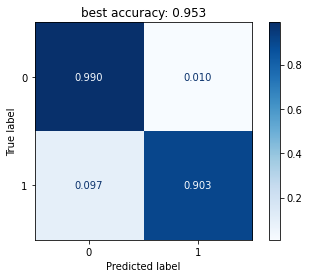

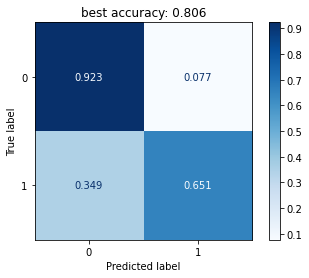

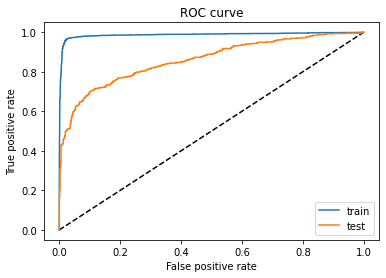

CPU times: user 1.63 s, sys: 19.9 ms, total: 1.65 s
Wall time: 1.65 s


In [93]:
df = my_df_text_mining(disaster_tweets.copy(), 'text')  # minor postprocessing: remove numbers and #,@, .... Special characters
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time fpr_1, tpr_1 = my_fit_cm(df, pipeMNB, "text", "target")

# Evaluation extended Modeling (weitere Spalten)

In [94]:
### AP: show result for one text line, or many example line

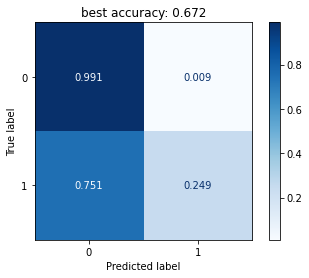

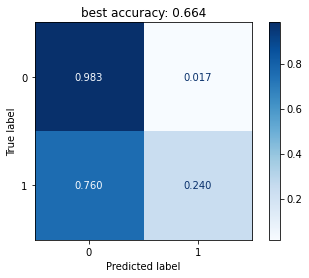

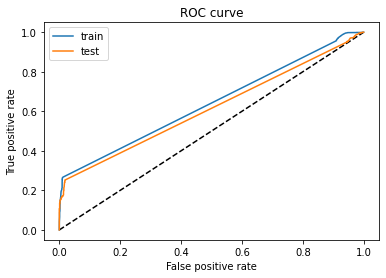

CPU times: user 607 ms, sys: 6.99 ms, total: 614 ms
Wall time: 613 ms


In [95]:
df = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time fpr_loc0, tpr_loc0 = my_fit_cm(df, pipeMNB, 'loc_gpe', "target")
# poor result: acc= 0.664

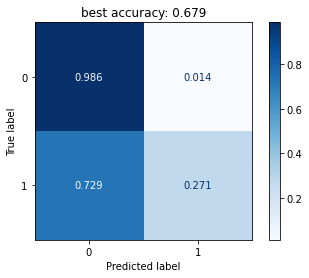

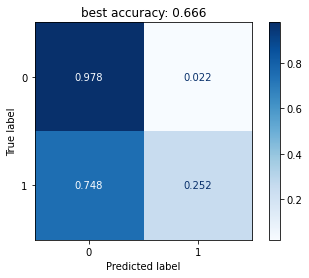

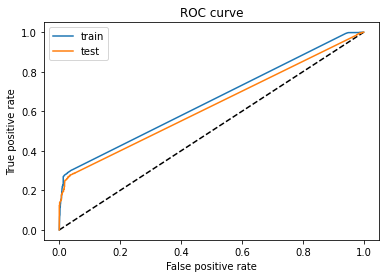

CPU times: user 656 ms, sys: 10 ms, total: 666 ms
Wall time: 667 ms


In [96]:
# next try
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression()) 
%time fpr_loc1, tpr_loc1 = my_fit_cm(df, pipe, 'loc_gpe', "target")

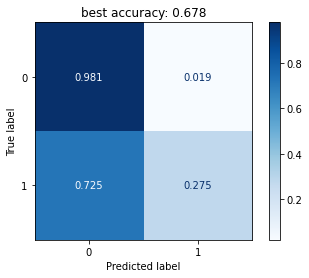

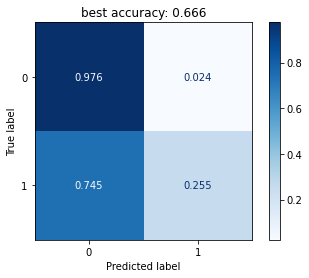

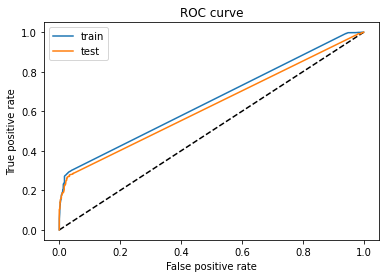

CPU times: user 589 ms, sys: 9.99 ms, total: 599 ms
Wall time: 606 ms


In [97]:
# next try
pipe = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time fpr_loc2, tpr_loc2 = my_fit_cm(df, pipe, 'loc_gpe', "target")

In [98]:
######## ERRORS ####### will keine stings :///// #######
"""
df_ = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')
df  = my_df_spacy_date_time(df_ , 'text')
feature_list = ['loc_gpe','date_time']
target = "target"

# next try
pipe = make_pipeline( LogisticRegression() ) 
%time my_fit_cm(df, pipe, feature_list, "target")
"""

'\ndf_ = my_df_spacy_locgpe(disaster_tweets.copy(), \'text\')\ndf  = my_df_spacy_date_time(df_ , \'text\')\nfeature_list = [\'loc_gpe\',\'date_time\']\ntarget = "target"\n\n# next try\npipe = make_pipeline( LogisticRegression() ) \n%time my_fit_cm(df, pipe, feature_list, "target")\n'

In [99]:
# some counts
df = disaster_tweets.copy()
df['_fire_'] = df['text'].apply(lambda x: str(x).count('fire') )
df['_@_'] = df['text'].apply(lambda x: str(x).count('@') )
df['_/_'] = df['text'].apply(lambda x: str(x).count('/') )
df

,id,keyword,location,text,target,_fire_,_@_,_/_
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,0,0
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,3
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,1,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,0,3
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0


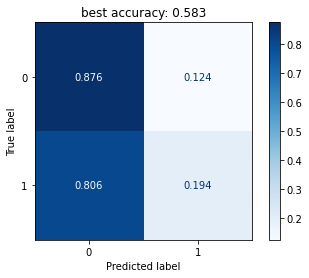

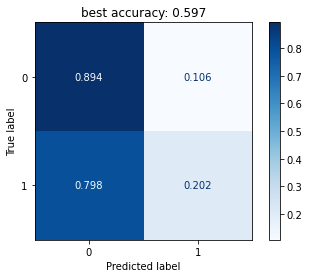

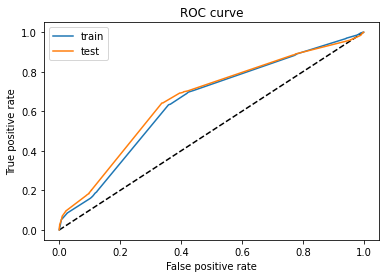

CPU times: user 693 ms, sys: 271 ms, total: 964 ms
Wall time: 664 ms


In [102]:
feature_list = ['_fire_','_@_','_/_']
# next try
pipe = make_pipeline( LogisticRegression() ) 
%time _ , _ = my_fit_cm(df, pipe, feature_list, "target")

# Final Model

In [101]:
# Performance